In [56]:
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

from skimage import feature
from scipy import stats, ndimage
from scipy.misc import factorial as fac

import photutils
import opticspy

from astropy import units
from astropy import stats
from astropy import visualization
from astropy import coordinates
from astropy.table import Table, vstack
from astropy.io import ascii, fits
from astropy.modeling import models, fitting, custom_model

In [18]:
NMPERRAD = 6.502e9 / 2.
NMPERASEC = NMPERRAD  / 206265.
PIXSIZE = 0.156  # arcsec
TILTFACTOR = PIXSIZE * NMPERASEC

In [19]:
def mk_rad_mask(r0, r1=None, norm=True, center=None, dtype=np.float, getxy=False):
    """
    Make a rectangular matrix of size (r0, r1) where the value of each 
    element is the Euclidean distance to **center**. If **center** is not 
    given, it is the middle of the matrix. If **norm** is True (default), 
    the distance is normalized to half the radius, i.e. values will range 
    from [-1, 1] for both axes.
    If only r0 is given, the matrix will be (r0, r0). If r1 is also given, 
    the matrix will be (r0, r1)
    To make a circular binary mask of (r0, r0), use
        mk_rad_mask(r0) < 1
    @param [in] r0 The width (and height if r1==None) of the mask.
    @param [in] r1 The height of the mask.
    @param [in] norm Normalize the distance such that 2/(r0, r1) equals a distance of 1.
    @param [in] getxy Return x, y-values instead of r
    @param [in] dtype Datatype to use for radial coordinates
    @param [in] center Set distance origin to **center** (defaults to the middle of the rectangle)
    """

    if not r1:
        r1 = r0
    if r0 < 0 or r1 < 0:
        print("mk_rad_mask(): r0 < 0 or r1 < 0?")

    if center != None and norm and sum(center)/len(center) > 1:
        raise ValueError("|center| should be < 1 if norm is set")	

    if center is None:
        if norm:
            center = (0, 0)
        else: 
            center = (r0 / 2.0, r1 / 2.0)

    # N.B. These are calculated separately because we cannot calculate  
    # 2.0/r0 first and multiply r0v with it depending on **norm**, this will 
    # yield different results due to rounding errors.
    if norm:
        r0v = np.linspace(-1-center[0], 1-center[0], r0).astype(dtype).reshape(-1,1)
        r1v = np.linspace(-1-center[1], 1-center[1], r1).astype(dtype).reshape(1,-1)
    else:
        r0v = np.linspace(0-center[0], r0-center[0], r0).astype(dtype).reshape(-1,1)
        r1v = np.linspace(0-center[1], r1-center[1], r1).astype(dtype).reshape(1,-1)

    if getxy:
        return r0v, r1v
    else:
        return np.sqrt(r0v**2 + r1v**2)

def zernike_rad(m, n, rho):
    """
    Make radial Zernike polynomial on coordinate grid **rho**.
    @param [in] m Radial Zernike index
    @param [in] n Azimuthal Zernike index
    @param [in] rho Radial coordinate grid
    @return Radial polynomial with identical shape as **rho**
    """
    if np.mod(n-m, 2) == 1:
        return 0.0

    wf = 0.0
    for k in range(int((n - m)/2) + 1):
        wf += rho**(n - 2.0*k) * (-1.0)**k * fac(n-k) / (fac(k) * fac((n + m)/2.0 - k) * fac((n - m)/2.0 - k ))

    return wf

def zernike(m, n, rho, phi, norm=False):
    """
    Calculate Zernike mode (m,n) on grid **rho** and **phi**.
    **rho** and **phi** should be radial and azimuthal coordinate grids of identical shape, respectively.
    @param [in] m Radial Zernike index
    @param [in] n Azimuthal Zernike index
    @param [in] rho Radial coordinate grid
    @param [in] phi Azimuthal coordinate grid
    @param [in] norm Normalize modes to unit variance
    @return Zernike mode (m,n) with identical shape as rho, phi
    @see <http://research.opt.indiana.edu/Library/VSIA/VSIA-2000_taskforce/TOPS4_2.html> 
         and <http://research.opt.indiana.edu/Library/HVO/Handbook.html>.
    """
    nc = 1.0
    if norm:
        nc = (2 * (n + 1)/(1 + (m==0)))**0.5
    if m > 0: 
        return nc * zernike_rad(m, n, rho) * np.cos(m * phi)
    if m < 0: 
        return nc * zernike_rad(-m, n, rho) * np.sin(-m * phi)
    return nc * zernike_rad(0, n, rho)

def noll_to_zern(j):
    """
    Convert linear Noll index to tuple of Zernike indices.
    j is the linear Noll coordinate, n is the radial Zernike index and m is the azimuthal Zernike index.
    @param [in] j Zernike mode Noll index
    @return (n, m) tuple of Zernike indices
    @see <https://oeis.org/A176988>.
    """
    if j == 0:
        raise ValueError("Noll indices start at 1, 0 is invalid.")

    n = 0
    j1 = j - 1
    while j1 > n:
        n += 1
        j1 -= n

    m = (-1)**j * ((n % 2) + 2 * int((j1 + ((n + 1) % 2)) / 2.0 ))
    return (n, m)

def zernikel(j, rho, phi, norm=False):
    n, m = noll_to_zern(j)
    return zernike(m, n, rho, phi, norm)

def zern_normalisation(nmodes=30):
    """
    Calculate normalisation vector.
    This function calculates a **nmodes** element vector with normalisation constants for 
    Zernike modes that have not already been normalised.
    @param [in] nmodes Size of normalisation vector.
    @see <http://research.opt.indiana.edu/Library/VSIA/VSIA-2000_taskforce/TOPS4_2.html> 
         and <http://research.opt.indiana.edu/Library/HVO/Handbook.html>.
    """

    nolls = (noll_to_zern(j+1) for j in range(nmodes))
    norms = [np.sqrt(2 * (n + 1)/(1 + (m==0))) for n, m  in nolls]
    return np.asanyarray(norms)

def calc_zern_basis(nmodes, rad, modestart=1, calc_covmat=False):
    """
    Calculate a basis of **nmodes** Zernike modes with radius **rad**.
    ((If **mask** is true, set everything outside of radius **rad** to zero (default). If this is not done, 
        the set of Zernikes will be **rad** by **rad** square and are not orthogonal anymore.)) --> Nothing 
        is masked, do this manually using the 'mask' entry in the returned dict.
    This output of this function can be used as cache for other functions.
    @param [in] nmodes Number of modes to generate
    @param [in] rad Radius of Zernike modes
    @param [in] modestart First mode to calculate (Noll index, i.e. 1=piston)
    @param [in] calc_covmat Return covariance matrix for Zernike modes, and its inverse
    @return Dict with entries 'modes' a list of Zernike modes, 'modesmat' a matrix of (nmodes, npixels), 
        'covmat' a covariance matrix for all these modes with 'covmat_in' its inverse, 'mask' is a binary 
        mask to crop only the orthogonal part of the modes.
    """

    if nmodes <= 0:
        return {'modes':[], 'modesmat':[], 'covmat':0, 'covmat_in':0, 'mask':[[0]]}
    if rad <= 0:
        raise ValueError("radius should be > 0")
    if modestart <= 0:
        raise ValueError("**modestart** Noll index should be > 0")

    # Use vectors instead of a grid matrix
    rvec = (np.arange(2.0 * rad) - rad) / rad
    r0 = rvec.reshape(-1, 1)
    r1 = rvec.reshape(1, -1)
    grid_rad = mk_rad_mask(2*rad)
    grid_ang = np.arctan2(r0, r1)

    grid_mask = grid_rad <= 1

    # Build list of Zernike modes, these are *not* masked/cropped
    zern_modes = [zernikel(zmode, grid_rad, grid_ang) for zmode in range(modestart, nmodes+modestart)]

    # Convert modes to (nmodes, npixels) matrix
    zern_modes_mat = np.r_[zern_modes].reshape(nmodes, -1)

    covmat = covmat_in = None
    if calc_covmat:
        # Calculate covariance matrix
        covmat = np.array([[np.sum(zerni * zernj * grid_mask) for zerni in zern_modes] for zernj in zern_modes])
        # Invert covariance matrix using SVD
        covmat_in = np.linalg.pinv(covmat)

    # Create and return dict
    return {'modes': zern_modes, 'modesmat': zern_modes_mat, 'covmat':covmat, 'covmat_in':covmat_in, 'mask': grid_mask}

def calc_slope(im, slopesi=None):
    """
    Calculate 2D slope of **im**, to be used to calculate unit Zernike 
    influence on SHWFS. If **slopesi** is given, use that (2, N) matrix for 
    fitting, otherwise generate and pseudo-invert slopes ourselves.
    @param [in] im Image to fit slopes to
    @param [in] slopesi Pre-computed **inverted** slope matrix to fit with, leave empty to auto-calculate.
    @return Tuple of (slope axis 0, slope axis 1)
    """

    if (slopesi == None):
        slopes = (np.indices(im.shape, dtype=float)/(np.r_[im.shape].reshape(-1,1,1))).reshape(2,-1)
        slopes2 = np.vstack([slopes, slopes[0]*0+1])
        slopesi = np.linalg.pinv(slopes2)

    return np.dot(im.reshape(1,-1), slopesi).ravel()[:2]

def calc_zern_infmat(subaps, nzern=10, zerncntr=None, zernrad=-1.0, singval=0.1, check=True, focus=1.0, wavelen=1.0, subapsize=1.0, pixsize=1.0, verb=0):
    """
    Given a sub aperture array pattern, calculate a matrix that converts 
    image shift vectors in pixel to Zernike amplitudes, and its inverse.
    The parameters **focus**, **wavelen**, **subapsize** and **pixsize** are 
    used for absolute calibration. If these are provided, the shifts in 
    pixel are translated to Zernike amplitudes where amplitude has unit 
    variance, i.e. the normalisation used by Noll (1976). These parameters
    should all be in meters.
    The data returned is a tuple of the following:
    1. Matrix to compute Zernike modes from image shifts
    2. Matrix to image shifts from Zernike amplitudes
    3. The set of Zernike polynomials used, from tim.zern.calc_zern_basis()
    4. The extent of the Zernike basis in units of **subaps** which can be used as extent keyword to imshow() when plotting **subaps**.
    To calculate the above mentioned matrices, we measure the x,y-slope of 
    all Zernike modes over all sub apertures, giving a matrix 
    `zernslopes_mat` that converts slopes for each Zernike matrix:
        subap_slopes_vec = zernslopes_mat . zern_amp_vec
    We multiply these slopes in radians/subaperture by 
        sfac = F * λ/2π/d/pix_pitch
    to obtain pixel shifts inside the sub images. We then have
        subap_shift_vec = sfac * zernslopes_mat . zern_amp_vec
    to get the inverse relation, we invert `zernslopes_mat`, giving:
        zern_amp_vec = (sfac * zernslopes_mat)^-1 . subap_shift_vec
        zern_amp_vec = zern_inv_mat . subap_shift_vec
    @param [in] subaps List of subapertures formatted as (low0, high0, low1, high1)
    @param [in] nzern Number of Zernike modes to model
    @param [in] zerncntr Coordinate to center Zernike around. If None, use center of **subaps**
    @param [in] zernrad Radius of the aperture to use. If negative, used as fraction **-zernrad**, otherwise used as radius in pixels.
    @param [in] singval Percentage of singular values to take into account when inverting the matrix
    @param [in] check Perform basic sanity checks
    @param [in] focus Focal length of MLA (in meter)
    @param [in] wavelen Wavelength used for SHWFS (in meter)
    @param [in] subapsize Size of single microlens (in meter)
    @param [in] pixsize Pixel size (in meter)
    @param [in] verb Show plots indicating fit geometry
    @return Tuple of (shift to Zernike matrix, Zernike to shift matrix, Zernike polynomials used, Zernike base shape in units of **subaps**)
    """

    # we already know pixel size in arcsec so multiply pixels in aperture and convert to radians.
    sfac = 2.0 * np.pi * 11. * PIXSIZE / 206265.

    # Geometry: offset between subap pattern and Zernike modes
    sasize = np.median(subaps[:,1::2] - subaps[:,::2], axis=0)
    if zerncntr == None:
        zerncntr = np.mean(subaps[:,::2], axis=0).astype(int)

    if zernrad < 0:
        pattrad = np.max(np.max(subaps[:, 1::2], 0) - np.min(subaps[:, ::2], 0))/2.0
        rad = int((pattrad*-zernrad)+0.5)
    else:
        rad = int(zernrad+0.5)
    saoffs = -zerncntr + np.r_[ [rad, rad] ]

    extent = zerncntr[1]-rad, zerncntr[1]+rad, zerncntr[0]-rad, zerncntr[0]+rad
    zbasis = calc_zern_basis(nzern, rad, modestart=2)

    # Chcek coordinates are sane
    if check:
        crop_coords = np.r_[ [[(subap[0]+saoffs[0], subap[2]+saoffs[1]) for subap in subaps] for zbase in zbasis['modes']] ]
        if np.max(crop_coords) > 2*rad or np.min(crop_coords) < 0:
            if verb > 2:
                import pylab as plt
                from matplotlib.collections import PatchCollection
                show_shwfs_vecs(subaps[:,::2]*0, subaps, img=None, extent=extent, title=None, scale=10, pause=False, fignum=None, keep=True)
                aprad = plt.Circle(tuple(zerncntr[::-1]), radius=rad, alpha=0.5)
                thisgca = plt.gca(); thisgca.add_artist(aprad)
                raw_input("...")
            raise ValueError("Not all sub apertures in Zernike radius!")

    slopes = (np.indices(sasize, dtype=float)/(np.r_[sasize].reshape(-1,1,1))).reshape(2,-1)
    slopes2 = np.vstack([slopes, slopes[0]*0+1])
    slopesi = np.linalg.pinv(slopes2)

    zernslopes = np.r_[ [[calc_slope(zbase[subap[0]+saoffs[0]:subap[1]+saoffs[0], subap[2]+saoffs[1]:subap[3]+saoffs[1]], slopesi=slopesi) for subap in subaps] for zbase in zbasis['modes']] ].reshape(nzern, -1)


    if verb > 2:
        # Inspect Zernike influence matrix
        import pylab as plt
        from matplotlib.collections import PatchCollection
        for zidx, (zslope, zbase) in enumerate(zip(zernslopes, zbasis['modes'])):
            plslope = (zslope/np.abs(zslope).mean()).reshape(-1,2)
            refpos = (subaps[:,1::2] + subaps[:,::2])/2

            show_shwfs_vecs(plslope, subaps, img=zbase, extent=extent, title=None, scale=10, pause=False, fignum=None, keep=True)
            plt.plot(zerncntr[1], zerncntr[0], 'p', markersize=20)

            raw_input("continue...")
            plt.close()

    # np.linalg.pinv() takes the cutoff wrt the *maximum*, we want a cut-off
    # based on the cumulative sum, i.e. the total included power, which is 
    # why we use svd() and not pinv().
    U, s, Vh = np.linalg.svd(zernslopes*sfac, full_matrices=False)
    cums = s.cumsum() / s.sum()
    nvec = np.argwhere(cums >= singval)[0][0]
    singval = cums[nvec]
    s[nvec+1:] = np.inf
    zern_inv_mat = np.dot(Vh.T, np.dot(np.diag(1.0/s), U.T))

    return zern_inv_mat, zernslopes*sfac, zbasis, extent

In [20]:
zern_normalisation()

array([ 1.        ,  2.        ,  2.        ,  1.73205081,  2.44948974,
        2.44948974,  2.82842712,  2.82842712,  2.82842712,  2.82842712,
        2.23606798,  3.16227766,  3.16227766,  3.16227766,  3.16227766,
        3.46410162,  3.46410162,  3.46410162,  3.46410162,  3.46410162,
        3.46410162,  2.64575131,  3.74165739,  3.74165739,  3.74165739,
        3.74165739,  3.74165739,  3.74165739,  4.        ,  4.        ])

In [21]:
def cart2pol(arr):
    """
    convert array of [x, y] vectors to [rho, theta]
    """
    x = arr[0]
    y = arr[1]
    rho = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return np.array([rho, theta])

def pol2cart(arr):
    """
    convert array of [rho, theta] vectors to [x, y]
    """
    rho = arr[0]
    theta = arr[1]
    x = rho * np.cos(theta)
    y = rho * np.sin(theta)
    return np.array([x, y])

def mk_pupil_model(size=400):
    """
    Use photutils to make an annular mask to use as a model for what a pupil should look like. 
    Arguments
    ---------
    size: int
        Image size in pixels (size x size)
        
    Returns
    -------
    mask:  2D np.ndarray
        Mask containing annular pupil model
    """
    annulus = np.zeros((size, size))
    # this mask will be 1 inside the annulus, 0 outside, and interpolated in pixels that are partially overlapped
    outer = photutils.geometry.circular_overlap_grid(-size/2., size/2., -size/2., size/2., size, size, 175, use_exact=0, subpixels=5)
    inner = photutils.geometry.circular_overlap_grid(-size/2., size/2., -size/2., size/2., size, size, 40, use_exact=0, subpixels=5)
    mask = annulus + outer - inner
    return mask

def plot_wfsfind(data, sources, ap_radius=5.0):
    positions = (sources['xcentroid'], sources['ycentroid'])
    apertures = photutils.CircularAperture(positions, r=ap_radius)
    norm = visualization.mpl_normalize.ImageNormalize(stretch=visualization.SqrtStretch())
    plt.imshow(data, cmap='gray', origin='lower', norm=norm, interpolation='None')
    apertures.plot(color='red', lw=1.5, alpha=0.5)

def wfsfind(data, fwhm=5.0, threshold=7.0, plot=False, ap_radius=5.0):
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
    mean, median, std = stats.sigma_clipped_stats(data, sigma=3.0, iters=5)
    daofind = photutils.DAOStarFinder(fwhm=fwhm, threshold=threshold*std)
    sources = daofind(data - median)
    if plot:
        plot_wfsfind(data, sources, ap_radius=ap_radius)
    return sources

def get_spacing(data):
    """
    Measure the WFS grid spacing which changes with telescope focus.
    
    Arguments
    ---------
    data: str or 2D ndarray
        WFS data to analyze
        
    Returns
    -------
    xspacing, yspacing: float, float
        Average grid spacing in X and Y axes
    """
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
    # sum along the axes and use Lomb-Scargle to measure the grid spacing in each direction
    xsum = np.sum(data, axis=0)
    ysum = np.sum(data, axis=1)
    x = np.arange(len(xsum))
    y = np.arange(len(ysum))
    k = np.linspace(5.0, 50., 1000.)  # look for spacings from 5 to 50 pixels (plenty of range)
    f = 1.0 / k  # convert spacing to frequency
    xp = stats.LombScargle(x, xsum).power(f)
    yp = stats.LombScargle(y, ysum).power(f) 
    # the peak of the power spectrum will coincide with the average spacing
    xspacing = k[xp.argmax()]
    yspacing = k[yp.argmax()]
    return xspacing, yspacing

def mk_reference(data, xoffset=0, yoffset=0, plot=False, pup_inner=45., pup_outer=175.):
    """
    Read WFS reference image and generate reference magnifications (i.e. grid spacing) and
    aperture positions.
    
    Arguments
    ---------
    data: FITS filename or 2D ndarray
        WFS reference image
    xoffset, yoffset: float
        Offsets in units of aperture spacing between the center of the reference aperture grid
        and the center of the pupil projected onto the grid.
    plot: bool
        Toggle plotting of the reference image and overlayed apertures
    pup_inner: float
        Reference radius in pixels of the central hole of the pupil
    pup_outer: float
        Reference radius in pixels of the outer extent of the pupil
        
    Returns
    -------
    ref: dict
        Keys - 
            xspacing: float
                Mean grid spacing along X axis (pixels)
            yspacing: float
                Mean grid spacing along Y axis (pixels)
            apertures: astropy.Table
                Reference apertures within pup_inner and pup_outer
            pup_coords: tuple (1D ndarray, 1D ndarray)
                X and Y positions of apertures in pupil coordinates
    """
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
    spots = wfsfind(data, fwhm=4.0, threshold=30.0, plot=plot)
    xcen = spots['xcentroid'].mean()
    ycen = spots['ycentroid'].mean()
    spacing = get_spacing(data)
    # just using the mean will be offset from the true center due to missing spots at edges.
    # find the spot closest to the mean and make it the center position of the pattern.
    dist = ((spots['xcentroid'] - xcen)**2 + (spots['ycentroid'] - ycen)**2)
    closest = np.argmin(dist)
    xoff = spots['xcentroid'][closest] - xcen
    yoff = spots['ycentroid'][closest] - ycen
    xcen += xoff
    ycen += yoff
    spots['xcentroid'] -= xcen + xoffset*spacing[0]
    spots['ycentroid'] -= ycen + yoffset*spacing[1]
    spots['dist'] = np.sqrt(spots['xcentroid']**2 + spots['ycentroid']**2)
    ref = {}
    ref['xspacing'] = spacing[0]
    ref['yspacing'] = spacing[1]
    spacing = (spacing[0] + spacing[1])/2.
    # we set the limit to half an aperture spacing in from the outer edge to make sure all of the points
    # lie within the zernike radius
    ref['apertures'] = spots[(spots['dist'] > pup_inner) & (spots['dist'] < pup_outer-0.5*spacing)]
    ref['pup_coords'] = (ref['apertures']['xcentroid']/pup_outer, ref['apertures']['ycentroid']/pup_outer)
    ref['pup_inner'] = pup_inner
    ref['pup_outer'] = pup_outer
    return ref

def center_pupil(data, plot=False):
    """
    Find the center of the pupil in a WFS image using skimage.feature.match_template(). This generates
    a correlation image and we centroid the peak of the correlation to determine the center.
    
    Arguments
    ---------
    data: str or 2D ndarray
        WFS image to analyze, either FITS file or ndarray image data
    plot: bool
        Toggle plotting of the correlation image
        
    Returns
    -------
    cen: tuple (float, float)
        X and Y pixel coordinates of the pupil center
    """
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
    # use skimage.feature.match_template() to do a fast cross-correlation between the WFS image and the pupil model.
    # the location of the peak of the correlation will be the center of the WFS pattern.
    mask = mk_pupil_model()
    match = feature.match_template(data, mask, pad_input=True)
    match[match < 0.95*match.max()] = 0
    cen = photutils.centroids.centroid_com(match)
    if plot:
        plt.imshow(match, interpolation=None, origin='lower')
    return cen

def get_apertures(data, ref, xcen, ycen, xspacing, yspacing):
    """
    Use the X/Y center positions and grid spacings to place the reference apertures onto the WFS
    frame.  Perform center-of-mass centroiding within each aperture.
    
    Arguments
    ---------
    data: str or 2D ndarray
        WFS image to analyze, either FITS file or ndarray image data
    ref: astropy.Table
        Table of reference aperture positions
    xcen, ycen: float, float
        X and Y positions of the pupil center
    xspacing, yspacing: float, float
        Aperture grid spacing along X and Y axes
        
    Returns
    -------
    apers: photutils.CircularAperture
        WFS apertures scaled and placed onto image
    masks: list of photutils.ApertureMask objects
        Masks used for aperture centroiding
    offsets: list of tuples
        X/Y offsets of spot centroids from aperture centers
    """
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
        
    # we use circular apertures here because they generate square masks of the appropriate size.
    # rectangular apertures produced masks that were sqrt(2) too large.
    # see https://github.com/astropy/photutils/issues/499 for details.  
    apers = photutils.CircularAperture(
        ((xspacing/ref['xspacing'])*ref['apertures']['xcentroid']+xcen,
        (yspacing/ref['yspacing'])*ref['apertures']['ycentroid']+ycen),
        r=(xspacing + yspacing)/4.
    )
    masks = apers.to_mask(method='subpixel')
    offsets = []
    for m in masks:
        subim = m.cutout(data)
        # center-of-mass centroiding is the fastest, most reliable method, especially for faint or elongated spots
        spotx, spoty = photutils.centroid_com(subim)
        offsets.append((spotx-m.shape[1]/2, spoty-m.shape[0]/2))
    offsets = np.array(offsets)
    return apers, masks, offsets
    
def get_slopes(file, ref, plot=False):
    """
    Analyze a WFS image and produce pixel offsets between reference and observed spot positions.
    
    Arguments
    ---------
    file: str
        FITS file containing WFS observation
    ref: astropy.Table
        Table of reference apertures
    plot: bool
        Toggle plotting of image with aperture overlays
        
    Returns
    -------
    slopes: list of tuples
        X/Y pixel offsets between measured and reference aperture positions.
    final_aps: astropy.Table
        Centroided observed apertures
    xspacing, yspacing: float, float
        Observed X and Y grid spacing
    xcen, ycen: float, float
        Center of pupil image
    data: 2D ndarray
        WFS image contained in 'file'
    """
    data = fits.open(file)[0].data
    mean, median, std = stats.sigma_clipped_stats(data, sigma=3.0, iters=5)
    data -= median
    xcen, ycen = center_pupil(data, plot=False)
    xspacing, yspacing = get_spacing(data)
    # get initial apertures, find mean offset, and fine tune the centration
    apers, masks, pos = get_apertures(data, ref, xcen, ycen, xspacing, yspacing)
    xcen += pos[0].mean()
    ycen += pos[1].mean()
    apers, masks, pos = get_apertures(data, ref, xcen, ycen, xspacing, yspacing)
    meas_pos = apers.positions + pos
    final_aps = photutils.CircularAperture(
            meas_pos,
            r=4.
    )
    ref_aps = photutils.CircularAperture(
        (ref['apertures']['xcentroid']+xcen, ref['apertures']['ycentroid']+ycen),
        r=(xspacing + yspacing) / 4.    
    )
    spacing = (xspacing + yspacing) / 2.
    ref_spacing = (ref['xspacing'] + ref['yspacing']) / 2.
    pup_size = ref['pup_outer']
    slopes = final_aps.positions - ref_aps.positions
    pup_coords = (ref_aps.positions - [xcen, ycen]) / [pup_size, pup_size]
    
    if plot:
        norm = visualization.mpl_normalize.ImageNormalize(stretch=visualization.SqrtStretch())
        plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='None')
        apers.plot(color='red')
        plt.scatter(xcen, ycen)
        final_aps.plot(color='yellow')
    return slopes.transpose(), pup_coords.transpose(), final_aps, (xspacing, yspacing), (xcen, ycen), data

<IPython.core.display.Javascript object>


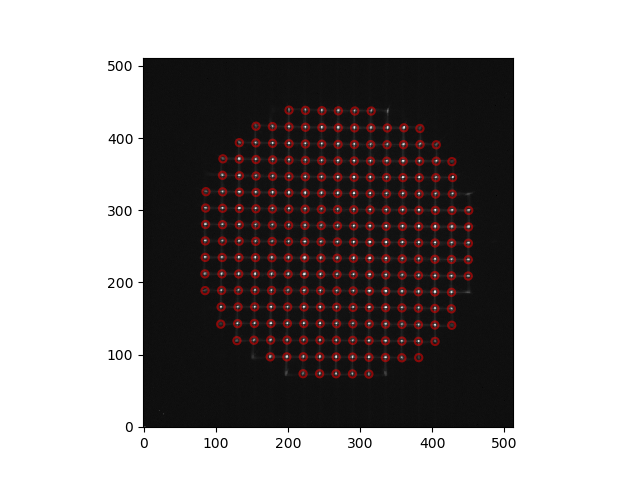

In [22]:
rs = mk_reference("/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera2_ref.fits", yoffset=-0.5, pup_inner=50., pup_outer=180., plot=True)
plt.show()

<IPython.core.display.Javascript object>


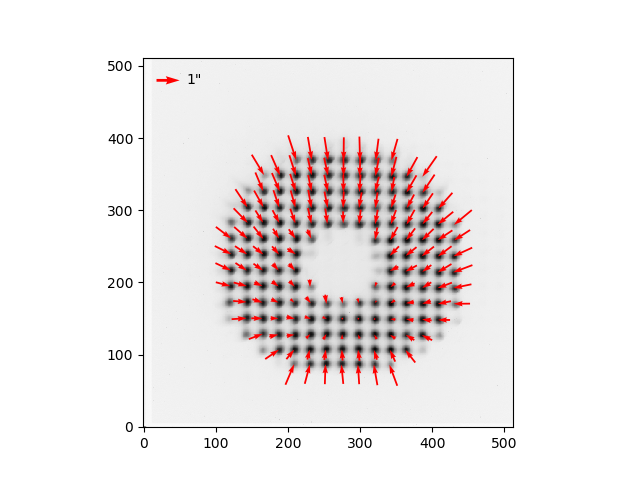

(22.027027027027025, 21.936936936936934)


In [114]:
slopes, coords, aps, spacing, cen, im = get_slopes("/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0094.fits", rs, plot=False)
refap = photutils.RectangularAperture(
    (rs['apertures']['xcentroid']+cen[0], rs['apertures']['ycentroid']+cen[1]), 
    w=22,
    h=22, 
    theta=0.0
)
x = aps.positions.transpose()[0]
y = aps.positions.transpose()[1]
u = slopes[0]
v = slopes[1]
norm = visualization.mpl_normalize.ImageNormalize(stretch=visualization.SqrtStretch())
plt.imshow(im, cmap='Greys', origin='lower', norm=norm, interpolation='None')
plt.quiver(x, y, u, v, scale_units='xy', scale=0.2, pivot='tip', color='red')
xl = [50.0]
yl = [480.0]
ul = [1.0/PIXSIZE]
vl = [0.0]
plt.quiver(xl, yl, ul, vl, scale_units='xy', scale=0.2, pivot='tip', color='red')
plt.text(60, 480, "1\"", verticalalignment='center')
plt.show()
print(spacing)
#plt.savefig("blah.png")

In [115]:
subaps = []
ap = rs['apertures']
bounds = np.array([ap['xcentroid'].data+180-11, ap['xcentroid'].data+180+11, ap['ycentroid'].data+180-11, ap['ycentroid'].data+180+11])

infmat = calc_zern_infmat(bounds.transpose(), singval=1.0, nzern=20, zerncntr=np.array([179.5, 179.5]), zernrad=180.0)

infmat[1].shape, slopes[0].shape

((20, 308), (154,))

In [116]:
slope_vec = -TILTFACTOR*slopes.transpose().ravel() / 206265.

zfit = np.dot(slope_vec, infmat[0])
coeffs = {}
norms = zern_normalisation()
#zfit[2] -= 1912.0
for i, z in enumerate(zfit):
    key = "Z%d" % (i+2)
    norm = norms[i+1]
    noll_coeff = z * 1.0e-3 / norm
    coeffs[key] = float("%.3f" % noll_coeff)
    print("%9.3f %d" % (z, i+2))
coeffs['Z2'] = 0.0
coeffs['Z3'] = 0.0

 3822.081 2
  -97.154 3
 2362.786 4
  -20.243 5
  465.754 6
  116.813 7
 -415.679 8
 -113.336 9
 -309.387 10
  236.332 11
  180.883 12
   16.792 13
  226.904 14
 -149.779 15
 -100.001 16
  -62.178 17
 -124.605 18
   -1.205 19
 -103.087 20
   46.092 21


Z4 =  1.364 Z20 Defocus
Z5 =  -0.008 Z22 Primary Astigmatism at 45
Z6 =  0.19 Z22 Primary Astigmatism at 0
Z7 =  0.041 Z31 Primary y Coma
Z8 =  -0.147 Z31 Primary x Coma
Z9 =  -0.04 Z33 y Trefoil
Z10 =  -0.109 Z33 x Trefoil
Z11 =  0.106 Z40 Primary Spherical
Z12 =  0.057 Z42 Secondary Astigmatism at 0
Z13 =  0.005 Z42 Secondary Astigmatism at 45
Z14 =  0.072 Z44 x Tetrafoil
Z15 =  -0.047 Z44 y Tetrafoil
Z16 =  -0.029 Z51 Secondary x Coma
Z17 =  -0.018 Z51 Secondary y Coma
Z18 =  -0.036 Z53 Secondary x Trefoil
Z20 =  -0.03 Z55 x Pentafoil
Z21 =  0.013 Z55 y Pentafoil


<IPython.core.display.Javascript object>


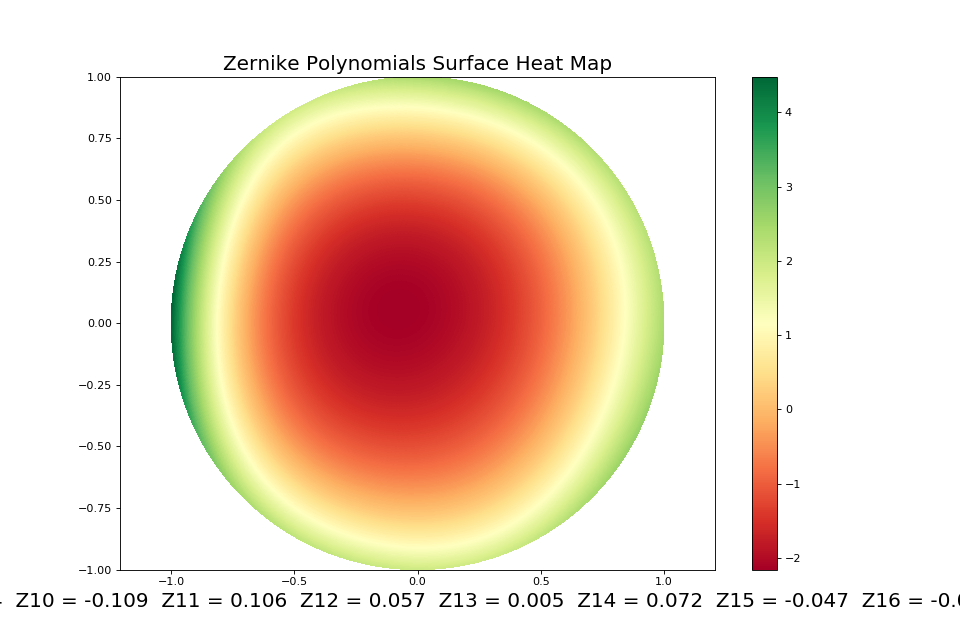

In [117]:
Z = opticspy.zernike.Coefficient(**coeffs)
Z.zernikemap()

In [118]:
Z.__coefficients__

[0,
 0.0,
 0.0,
 1.364,
 -0.008,
 0.19,
 0.041,
 -0.147,
 -0.04,
 -0.109,
 0.106,
 0.057,
 0.005,
 0.072,
 -0.047,
 -0.029,
 -0.018,
 -0.036,
 -0.0,
 -0.03,
 0.013,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

0.0807876898275 1273.31723574


<IPython.core.display.Javascript object>


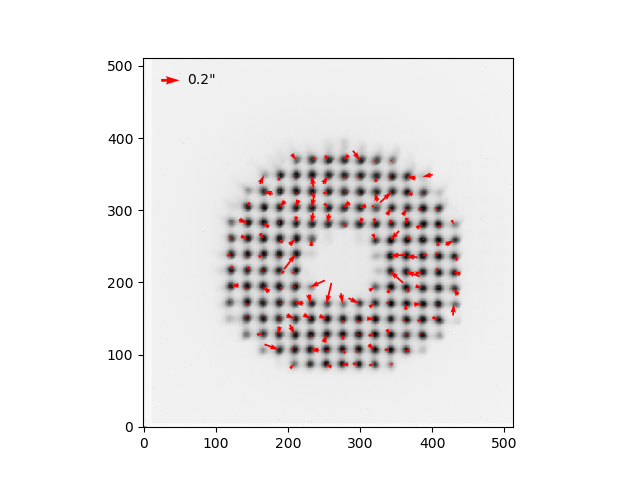

In [119]:
pred = np.dot(zfit, infmat[1])
pred = -(206265./TILTFACTOR) * pred.reshape(slopes.shape[1], 2).transpose()
np.sqrt((pred[0] - slopes[0])**2 + (pred[1] - slopes[1])**2).mean()
diff = slopes - pred

rms = PIXSIZE*np.sqrt((diff[0]**2 + diff[1]**2).mean())
print(rms, rms*NMPERASEC)
gnorm = visualization.mpl_normalize.ImageNormalize(stretch=visualization.SqrtStretch())
plt.imshow(im, cmap='Greys', origin='lower', norm=gnorm, interpolation='None')
plt.quiver(x, y, diff[0], diff[1], scale_units='xy', scale=0.05, pivot='tip', color='red')
xl = [50.0]
yl = [480.0]
ul = [0.2/PIXSIZE]
vl = [0.0]
plt.quiver(xl, yl, ul, vl, scale_units='xy', scale=0.05, pivot='tip', color='red')
plt.text(60, 480, "0.2\"", verticalalignment='center')
plt.show()

<IPython.core.display.Javascript object>


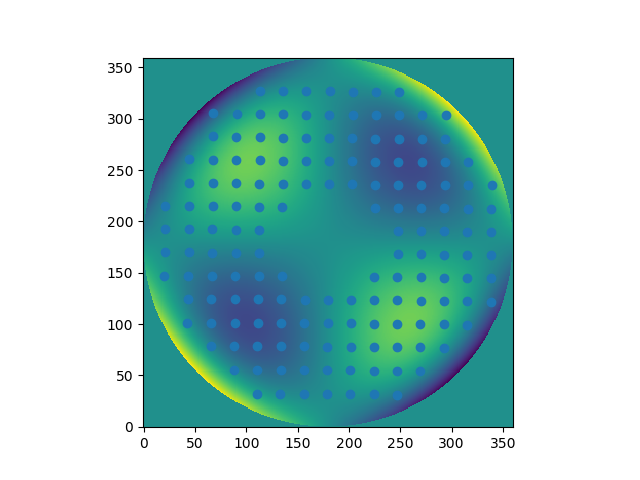

In [120]:
z = calc_zern_basis(24, 180, modestart=2)
len(z['modes'])

plt.imshow(z['modes'][11]*z['mask'], origin='lower')
plt.scatter(rs['apertures']['xcentroid']+180, rs['apertures']['ycentroid']+180)
plt.show()

<IPython.core.display.Javascript object>


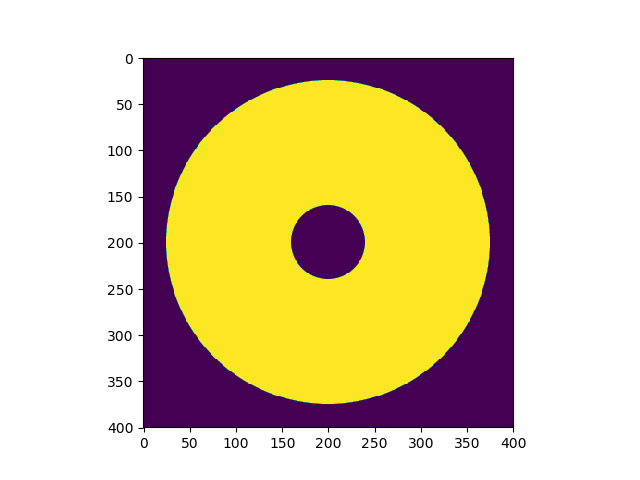

In [30]:
mask = mk_pupil_model()
plt.imshow(mask)
plt.show()

In [31]:
file = "/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0373.fits"
center = ascii.read("/Users/tim/MMT/shwfs/mmirs2_reference.center")
ref = ascii.read("/Users/tim/MMT/shwfs/mmirs2_sysfile.cntr")
ref1_fits = "/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera1_ref.fits"
ref2_fits = "/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera2_ref.fits"
# test images from 20170110: 1, 7, 44, 61, 126, 131-138, 161-168, 183-189, 194-198, 298-299, 327, 369-372
test_fits = "/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0335.fits"

im = fits.open(file)[0].data
ref1_im = fits.open(ref1_fits)[0].data
ref2_im = fits.open(ref2_fits)[0].data
test = fits.open(test_fits)[0].data

<IPython.core.display.Javascript object>


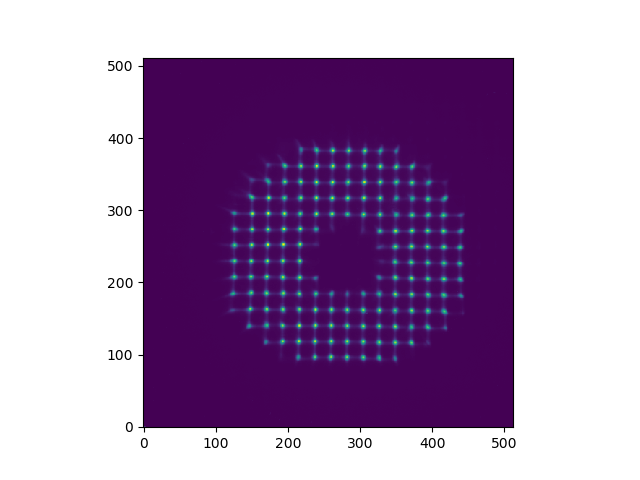

In [32]:
plt.imshow(test, interpolation='nearest', origin='lower')
#plt.scatter(ref['col1'], ref['col2'], color='purple')
#plt.scatter(center['col1'], center['col2'], marker='x', color='white')
#plt.scatter(271, 229, marker='x', color='white')
plt.show()

<IPython.core.display.Javascript object>


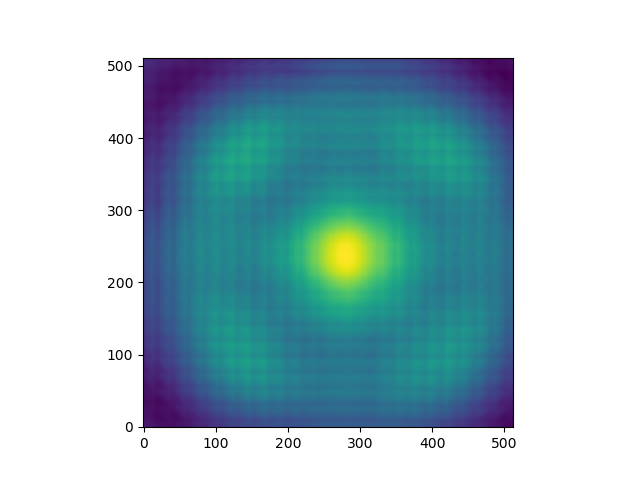

In [33]:
# use skimage.feature.match_template() to do a fast cross-correlation between the WFS image and the pupil model.
# the location of the peak of the correlation will be the center of the WFS pattern.
result = feature.match_template(test, mask, pad_input=True)
plt.imshow(result, interpolation='nearest', origin='lower')
plt.show()

<IPython.core.display.Javascript object>


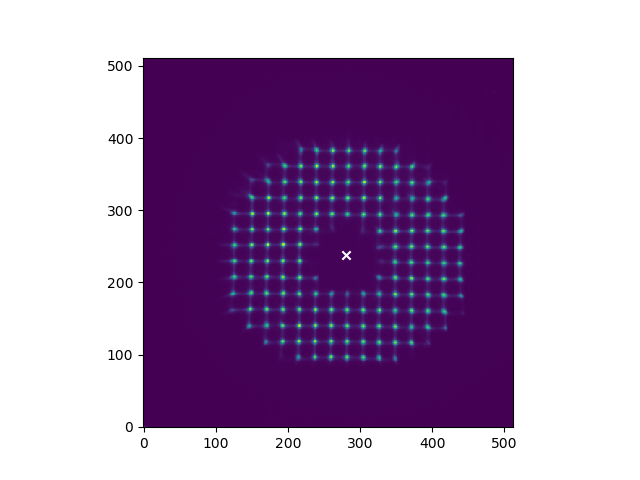

In [34]:
# the correlation image is somewhat complicated, but the peak is distinct as long as there are detectable WFS spots.
# clip the image at 90% of the peak and then do a center-of-mass centroid on it. 
plt.imshow(test, interpolation='nearest', origin='lower')
result[result < 0.9*result.max()] = 0
cen = photutils.centroids.centroid_com(result)
plt.scatter(cen[0], cen[1], marker='x', color='white')
plt.show()

In [35]:
# ndimage and photutils should give the same answer for CoM centroids...
ndimage.center_of_mass(result)

(237.6522189842631, 279.98355777336872)

<IPython.core.display.Javascript object>


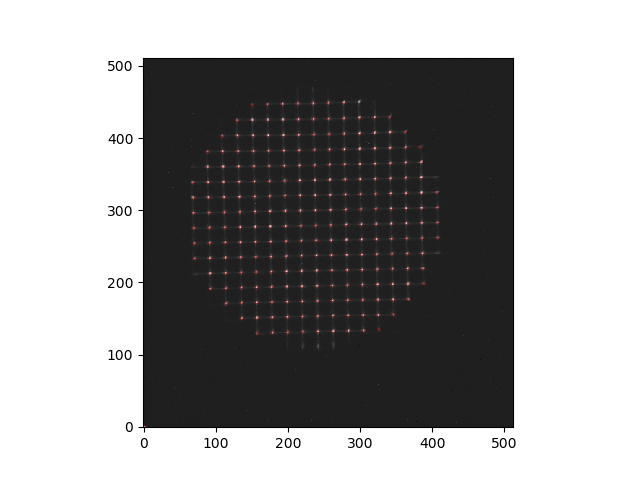

In [36]:
ref_file = "/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera1_ref.fits"
ref_data = fits.open(ref_file)[0].data
mean, median, std = stats.sigma_clipped_stats(ref_data, sigma=3.0, iters=5)

daofind = photutils.DAOStarFinder(fwhm=4, threshold=30.0*std)
#starfind = photutils.IRAFStarFinder(fwhm=2.0, threshold=5.0*std)

dao_sources = daofind(ref_data - median)
#iraf_sources = starfind(ref_data - median)

plot_wfsfind(ref_data, dao_sources, ap_radius=0.5)
plt.show()

<IPython.core.display.Javascript object>


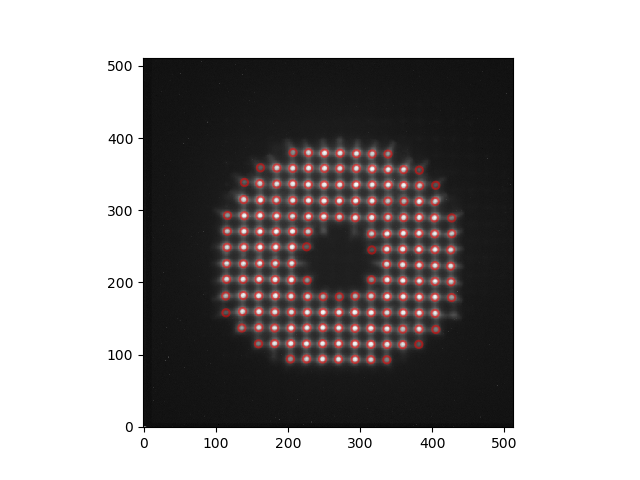

In [37]:
s = wfsfind("/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0232.fits", fwhm=7.0, plot=True)
s.sort(['xcentroid'])
plt.show()

<IPython.core.display.Javascript object>


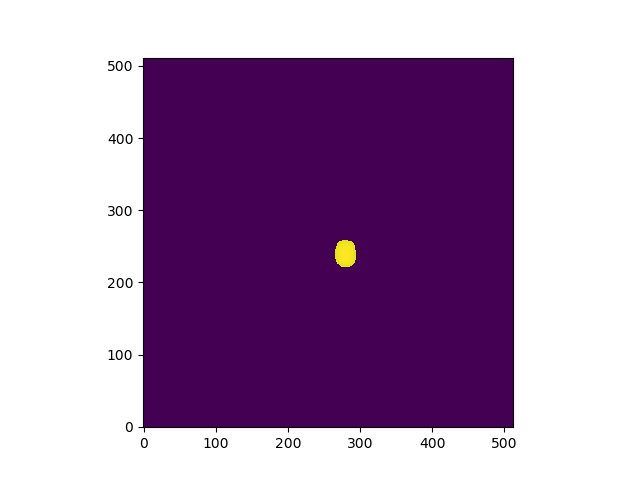

In [38]:
c = center_pupil("/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0320.fits", plot=True)
plt.show()

<IPython.core.display.Javascript object>


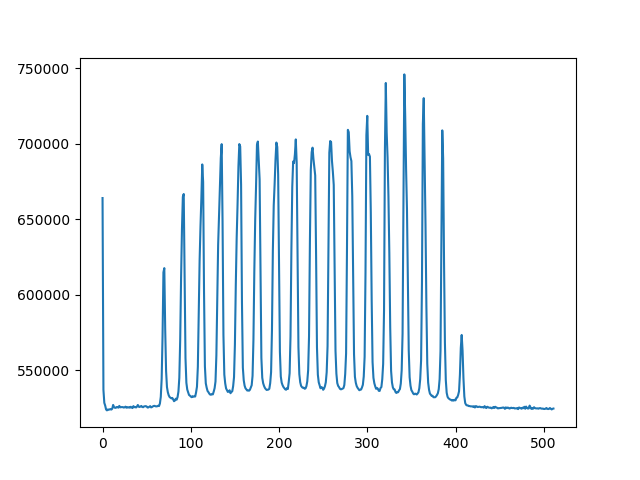

(21.036036036036034, 21.036036036036034)


In [39]:
#data = fits.open("/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera1_ref.fits")[0].data
data = fits.open("/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera1_ref.fits")[0].data
x = np.sum(data, axis=0)
y = np.sum(data, axis=1)
plt.plot(x)
plt.show()
print(get_spacing(data))

<IPython.core.display.Javascript object>


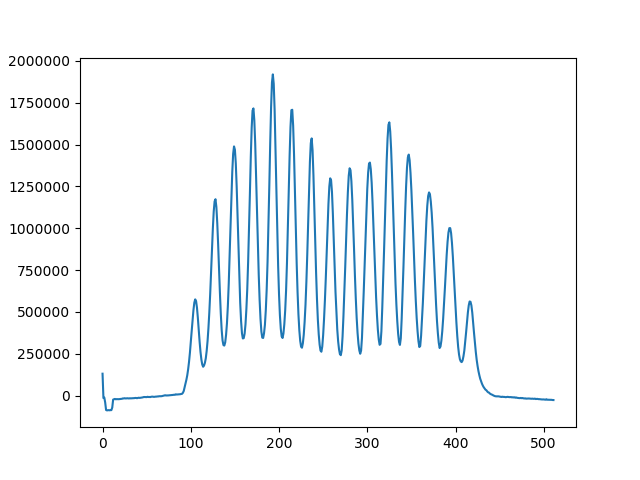

(22.117117117117115, 22.522522522522522)


In [40]:
data = fits.open("/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0138.fits")[0].data
mean, median, std = stats.sigma_clipped_stats(data, sigma=3.0, iters=5)
data -= median
x = np.sum(data, axis=0)
y = np.sum(data, axis=1)
plt.plot(x)
plt.show()
print(get_spacing(data))

<IPython.core.display.Javascript object>


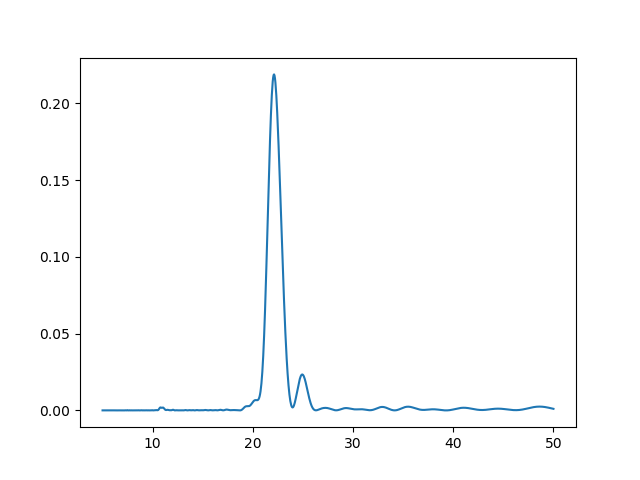

In [41]:
d = np.sum(data, axis=0)
t = np.arange(len(d))
k = np.linspace(5.0, 50., 1000.)
p = stats.LombScargle(t, d).power(1.0/k)
plt.plot(k, p)
plt.show()

In [121]:
ACT = 104
NODE = 3222
BRAD = 3228.5

In [195]:
# for each node, the influence from each actuator
surf2act = np.fromfile("../Surf2ActTEL_32.bin", dtype=np.float32).reshape(ACT, NODE).transpose()
nodes = ascii.read("../bcv_node_coordinates.dat", names=["bcv_id", "bcv_x", "bcv_y", "bcv_z"])
for ax in ["bcv_x", "bcv_y"]:
    nodes[ax] /= BRAD
nodes['bcv_rho'] = np.sqrt(nodes['bcv_x']**2 + nodes['bcv_y']**2)
nodes['bcv_phi'] = np.arctan2(nodes['bcv_y'], nodes['bcv_x'])

In [196]:
len(zfit)

20

In [197]:
def zern_phase(zvec, rho, phi, modestart=2):
    phase = 0.0
    for i, z in enumerate(zvec):
        l = i + modestart
        ph = z * zernikel(l, rho, phi)
        phase += ph
    return phase
zern_phase(ztest, 1.0, np.pi/8)

707.10678118654744

In [316]:
ztest = np.zeros(20)
ztest[8] = 500.0
ztest

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  500.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.])

<IPython.core.display.Javascript object>


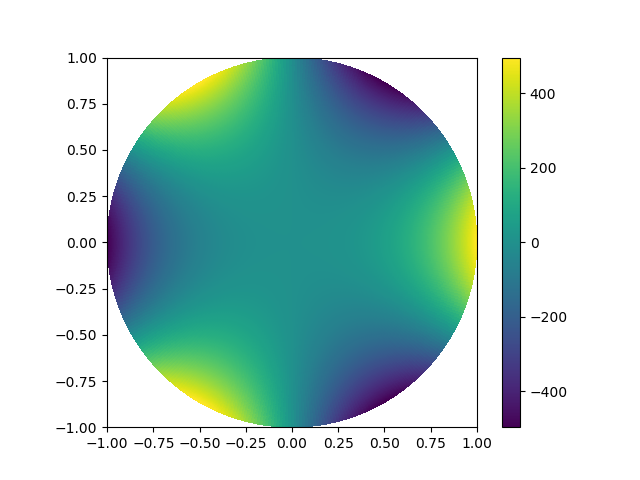

In [317]:
rho = np.linspace(0.0, 1.0, 400)
phi = np.linspace(0, 2*np.pi, 400)
[p, r] = np.meshgrid(phi, rho)
x = r * np.cos(p)
y = r * np.sin(p)
ph = zern_phase(ztest, r, p, modestart=2)
plt.pcolormesh(x, y, ph)
plt.gca().set_aspect('equal')
plt.colorbar()
plt.show()

In [319]:
ztest = np.zeros(20)
ztest[7] = 500.0
print(ztest)
mir_ph = 0.5*zern_phase(ztest, nodes['bcv_rho'], nodes['bcv_phi'])

np.dot(mir_ph, surf2act)

[   0.    0.    0.    0.    0.    0.    0.  500.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.]


20.7712821465
13.1636353926
5.25117217799
6.38250403845
5.74255560742
-10.3392919701
-13.5538186135
-7.57732274469
-3.61077591138
-14.6545942644
-2.18659916022


In [308]:
ztest = np.zeros(20)
ztest[3] = 1000.0
print(ztest)
mir_ph = 0.5*zern_phase(ztest, nodes['bcv_rho'], nodes['bcv_phi'])

np.dot(mir_ph, surf2act)

[    0.     0.     0.  1000.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.]


-2.40413613704
-5.32637921154
-6.49496311456
-1.15894132495
-1.95779583994
-11.9683349904
0.942385128663
5.12141916924
2.51449915618
-10.3472205021
3.33027532843


In [320]:
nodes

bcv_id,bcv_x,bcv_y,bcv_z,bcv_rho,bcv_phi
int64,float64,float64,float64,float64,float64
5,0.0,-1.0,679.205,1.0,-1.57079632679
10,0.00696918073409,-0.999975220691,679.204,0.999999505738,-1.5638270862
15,0.0418336688865,-0.999123431934,679.204,0.999998844046,-1.52895039801
20,0.0936224252749,-0.995607867431,679.205,1.0000000921,-1.47703659865
25,0.113820659749,-0.993501626142,679.205,1.00000031187,-1.45672849841
31,0.161375251665,-0.986891745393,679.204,0.999998644486,-1.40871209415
43,0.0859284497445,-0.982282793867,670.313,0.98603406919,-1.48354012798
44,0.120300449125,-0.982282793867,672.585,0.989621991059,-1.44893290375
49,0.188877187548,-0.982000929224,679.205,1.00000020849,-1.38077773907
